In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# Any results you write to the current directory are saved as output.

In [2]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import gc
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from sklearn.preprocessing import LabelEncoder

In [3]:
# Training data
app_train = pd.read_csv('data/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Testing data features
app_test = pd.read_csv('data/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
app_train['TARGET'].value_counts()
print('The proportion of label 1 is %.2f' % (sum(app_train['TARGET']==1)/app_train.shape[0]*100), '%')

The proportion of label 1 is 8.07 %


In [6]:
# 该函数确定数据集每一列的缺失值个数及占比
def missing_values_table(df):
    #Total missing values
    mis_val = df.isnull().sum()
    
    #Percentages of missing values
    mis_val_percent = df.isnull().sum() * 100 / df.shape[0]
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1)
    
    # Rename the columns
    mis_val_table_rename_columns = mis_val_table.rename(columns = {0: 'Missing Values', 1: 'Percentage'})
    
    #Sort the table
    mis_val_table_rename_columns = mis_val_table_rename_columns[
        mis_val_table_rename_columns.iloc[:, 1]!=0].sort_values('Percentage', ascending=False).round(1) #round(1) to keep only one decimal
    
    #Print information
    print('The total dataframe has ' + str(df.shape[1]) + ' columns')
    print('There are ' + str(mis_val_table_rename_columns.shape[0]) + ' columns')
    
    return mis_val_table_rename_columns

In [7]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

The total dataframe has 122 columns
There are 67 columns


,Missing Values,Percentage
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [8]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [9]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [10]:
app_test.dtypes.value_counts()

float64    65
int64      40
object     16
dtype: int64

In [11]:
# 该部分将'object'类型的columns转换为数值型，One-hot

app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 246)
Testing Features shape:  (48744, 242)


In [12]:
# 对齐train和test的数据，丢掉无用的列
train_labels = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 242)


In [13]:
# 删除部分列的异常值
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED'] == 365243

app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_test['DAYS_EMPLOYED_ANOM'] = app_test['DAYS_EMPLOYED'] == 365243

app_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 244)
Testing Features shape:  (48744, 243)


In [14]:
# 查看数据的Correlations

correlations = app_train.corr()['TARGET'].sort_values()

# 输出最相关的30个特征
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [15]:
#该部分加入专业知识特征

app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

print('Domain Training Features shape: ', app_train_domain.shape)
print('Domain Testing Features shape: ', app_test_domain.shape)

Domain Training Features shape:  (307511, 248)
Domain Testing Features shape:  (48744, 247)


** Manual Feature Engineering (Part 1) : bureau.csv**

分为四步：
2. 将bureau的数值类型特征抽取出来
3. 将bureau的字符类型特征抽取出来
4. 将上述特征加入train和test

In [16]:
# Read in bureau
bureau = pd.read_csv('data/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [17]:
# Step 2: 将数值特征的抽取出来

def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    
    # First calculate counts
    counts = pd.DataFrame(df.groupby(group_var, as_index = False)[df.columns[1]].count()).rename(columns = {df.columns[1]: '%s_counts' % df_name})
    
    # Group by the specified variable and calculate the statistics
    agg = df.groupby(group_var).agg(['mean', 'max', 'min', 'sum']).reset_index()
    
    # Need to create new column names
    columns = [group_var]
    
    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
              
    #  Rename the columns
    agg.columns = columns
    
    # Merge with the counts
    agg = agg.merge(counts, on = group_var, how = 'left')
    
    return agg

bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_mean,...,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum,bureau_counts
0,100001,-735.000000,-49,-1572,-5145,0.0,0,0,0,82.428571,...,0.0,-93.142857,-6,-155,-652,3545.357143,10822.5,0.0,24817.5,7
1,100002,-874.000000,-103,-1437,-6992,0.0,0,0,0,-349.000000,...,0.0,-499.875000,-7,-1185,-3999,0.000000,0.0,0.0,0.0,8
2,100003,-1400.750000,-606,-2586,-5603,0.0,0,0,0,-544.500000,...,0.0,-816.000000,-43,-2131,-3264,NaN,NaN,NaN,0.0,4
3,100004,-867.000000,-408,-1326,-1734,0.0,0,0,0,-488.500000,...,0.0,-532.000000,-382,-682,-1064,NaN,NaN,NaN,0.0,2
4,100005,-190.666667,-62,-373,-572,0.0,0,0,0,439.333333,...,0.0,-54.333333,-11,-121,-163,1420.500000,4261.5,0.0,4261.5,3


In [18]:
# 第3步：将字符型特征的抽取出来

def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [19]:
# Step 4: 将上述特征加入到train和test中

In [20]:
# 将bureau_agg加入到train和test中
train = app_train_domain.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
test = app_test_domain.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

In [21]:
# 将bureau_counts加入到train和test中
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

In [22]:
print('Before align train.shape: ', train.shape)
print('Before align test.shape: ', test.shape)

train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

print('After align train.shape: ', train.shape)
print('After align test.shape: ', test.shape)

Before align train.shape:  (307511, 343)
Before align test.shape:  (48744, 342)
After align train.shape:  (307511, 343)
After align test.shape:  (48744, 342)


** Manual Feature Engineering (Part 2) : bureau_balance.csv**

分为三步：
1. 将bureau_balance的数值类型特征抽取出来，合并到SK_ID_BUREAU下
2. 将bureau_balance的字符类型特征抽取出来，合并到SK_ID_BUREAU下
3. 将合并的SK_ID_BUREAU按照数值类型抽取特征，加入train和test

In [23]:
# Read in bureau balance
bureau_balance = pd.read_csv('data/bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [24]:
bureau_balance.shape

(27299925, 3)

In [25]:
# Step 1: 将数值特征的抽取出来
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_counts
0,5001709,-48.0,0,-96,-4656,97
1,5001710,-41.0,0,-82,-3403,83
2,5001711,-1.5,0,-3,-6,4
3,5001712,-9.0,0,-18,-171,19
4,5001713,-10.5,0,-21,-231,22


In [26]:
# Step 2: 将字符特征的抽取出来
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [27]:
#将上述特征按照 'SK_ID_BUREAU'合并
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

In [28]:
# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

In [29]:
bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_counts,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,-48.0,0,-96,-4656,97,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,-41.0,0,-82,-3403,83,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,-1.5,0,-3,-6,4,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,-9.0,0,-18,-171,19,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,-10.5,0,-21,-231,22,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [30]:
# Step 3: 将合并后的bureau_by_loa按照'SK_ID_CURR'抽取特征
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,client_bureau_balance_MONTHS_BALANCE_mean_sum,client_bureau_balance_MONTHS_BALANCE_max_mean,client_bureau_balance_MONTHS_BALANCE_max_max,client_bureau_balance_MONTHS_BALANCE_max_min,client_bureau_balance_MONTHS_BALANCE_max_sum,client_bureau_balance_MONTHS_BALANCE_min_mean,...,client_bureau_balance_STATUS_C_count_norm_sum,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum,client_counts
0,100001.0,-11.785714,-0.5,-25.5,-82.5,0.0,0,0,0,-23.571429,...,3.088683,4.285714,9,0,30.0,0.214590,0.500000,0.0,1.502129,7
1,100002.0,-21.875000,-1.5,-39.5,-175.0,-15.5,0,-32,-124,-28.250000,...,1.403409,1.875000,3,0,15.0,0.161932,0.500000,0.0,1.295455,8
2,100005.0,-3.000000,-1.0,-6.0,-9.0,0.0,0,0,0,-6.000000,...,0.384615,0.666667,1,0,2.0,0.136752,0.333333,0.0,0.410256,3
3,100010.0,-46.000000,-19.5,-72.5,-92.0,-28.5,-2,-55,-57,-63.500000,...,1.444444,0.000000,0,0,0.0,0.000000,0.000000,0.0,0.000000,2
4,100013.0,-28.250000,-19.5,-34.0,-113.0,0.0,0,0,0,-56.500000,...,1.588142,10.250000,40,0,41.0,0.254545,1.000000,0.0,1.018182,4


In [31]:
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [32]:
print('Before align train.shape: ', train.shape)
print('Before align test.shape: ', test.shape)

train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

print('After align train.shape: ', train.shape)
print('After align test.shape: ', test.shape)

Before align train.shape:  (307511, 428)
Before align test.shape:  (48744, 427)
After align train.shape:  (307511, 428)
After align test.shape:  (48744, 427)


In [33]:
gc.enable()
del app_train, app_test, app_train_domain, app_test_domain, bureau, bureau_balance, bureau_agg, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client
gc.collect()

168

** Manual Feature Engineering (Part 3) : previous_application.csv**

分为三步：
1. 将previous_application的数值类型特征抽取出来
2. 将previous_application的字符类型特征抽取出来
3. 将抽取的特征加入train和test

In [34]:
previous = pd.read_csv('data/previous_application.csv')
previous.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# 抽取数值型特征
previous_agg = agg_numeric(previous.drop(columns = ['SK_ID_PREV']), group_var = 'SK_ID_CURR', df_name = 'previous_apply')
previous_agg.head()

,SK_ID_CURR,previous_apply_AMT_ANNUITY_mean,previous_apply_AMT_ANNUITY_max,previous_apply_AMT_ANNUITY_min,previous_apply_AMT_ANNUITY_sum,previous_apply_AMT_APPLICATION_mean,previous_apply_AMT_APPLICATION_max,previous_apply_AMT_APPLICATION_min,previous_apply_AMT_APPLICATION_sum,previous_apply_AMT_CREDIT_mean,...,previous_apply_DAYS_LAST_DUE_sum,previous_apply_DAYS_TERMINATION_mean,previous_apply_DAYS_TERMINATION_max,previous_apply_DAYS_TERMINATION_min,previous_apply_DAYS_TERMINATION_sum,previous_apply_NFLAG_INSURED_ON_APPROVAL_mean,previous_apply_NFLAG_INSURED_ON_APPROVAL_max,previous_apply_NFLAG_INSURED_ON_APPROVAL_min,previous_apply_NFLAG_INSURED_ON_APPROVAL_sum,previous_apply_counts
0,100001,3951.000,3951.000,3951.000,3951.000,24835.50,24835.5,24835.5,24835.5,23787.00,...,-1619.0,-1612.000000,-1612.0,-1612.0,-1612.0,0.000000,0.0,0.0,0.0,1
1,100002,9251.775,9251.775,9251.775,9251.775,179055.00,179055.0,179055.0,179055.0,179055.00,...,-25.0,-17.000000,-17.0,-17.0,-17.0,0.000000,0.0,0.0,0.0,1
2,100003,56553.990,98356.995,6737.310,169661.970,435436.50,900000.0,68809.5,1306309.5,484191.00,...,-3163.0,-1047.333333,-527.0,-1976.0,-3142.0,0.666667,1.0,0.0,2.0,3
3,100004,5357.250,5357.250,5357.250,5357.250,24282.00,24282.0,24282.0,24282.0,20106.00,...,-724.0,-714.000000,-714.0,-714.0,-714.0,0.000000,0.0,0.0,0.0,1
4,100005,4813.200,4813.200,4813.200,4813.200,22308.75,44617.5,0.0,44617.5,20076.75,...,-466.0,-460.000000,-460.0,-460.0,-460.0,0.000000,0.0,0.0,0.0,2


In [36]:
# 抽取字符型特征
previous_counts = count_categorical(previous, group_var = 'SK_ID_CURR', df_name = 'previous_apply')
previous_counts.head()

,previous_apply_NAME_CONTRACT_TYPE_Cash loans_count,previous_apply_NAME_CONTRACT_TYPE_Cash loans_count_norm,previous_apply_NAME_CONTRACT_TYPE_Consumer loans_count,previous_apply_NAME_CONTRACT_TYPE_Consumer loans_count_norm,previous_apply_NAME_CONTRACT_TYPE_Revolving loans_count,previous_apply_NAME_CONTRACT_TYPE_Revolving loans_count_norm,previous_apply_NAME_CONTRACT_TYPE_XNA_count,previous_apply_NAME_CONTRACT_TYPE_XNA_count_norm,previous_apply_WEEKDAY_APPR_PROCESS_START_FRIDAY_count,previous_apply_WEEKDAY_APPR_PROCESS_START_FRIDAY_count_norm,...,previous_apply_PRODUCT_COMBINATION_POS industry without interest_count,previous_apply_PRODUCT_COMBINATION_POS industry without interest_count_norm,previous_apply_PRODUCT_COMBINATION_POS mobile with interest_count,previous_apply_PRODUCT_COMBINATION_POS mobile with interest_count_norm,previous_apply_PRODUCT_COMBINATION_POS mobile without interest_count,previous_apply_PRODUCT_COMBINATION_POS mobile without interest_count_norm,previous_apply_PRODUCT_COMBINATION_POS other with interest_count,previous_apply_PRODUCT_COMBINATION_POS other with interest_count_norm,previous_apply_PRODUCT_COMBINATION_POS others without interest_count,previous_apply_PRODUCT_COMBINATION_POS others without interest_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0,0.000000,1,1.000000,0,0.0,0,0.0,1,1.000000,...,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
100002,0,0.000000,1,1.000000,0,0.0,0,0.0,0,0.000000,...,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
100003,1,0.333333,2,0.666667,0,0.0,0,0.0,1,0.333333,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,1,1.000000,0,0.0,0,0.0,1,1.000000,...,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
100005,1,0.500000,1,0.500000,0,0.0,0,0.0,1,0.500000,...,0,0.0,1,0.5,0,0.0,0,0.0,0,0.0


In [37]:
print('Previous aggregated shape: ', previous_agg.shape)
print('Previous categorical counts shape: ', previous_counts.shape)

Previous aggregated shape:  (338857, 78)
Previous categorical counts shape:  (338857, 286)


In [38]:
# Merge in the previous information
print('Before Merge train.shape: ', train.shape)
print('Before Merge test.shape: ', test.shape)

train = train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test = test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

print('After Merge train.shape: ', train.shape)
print('After Merge test.shape: ', test.shape)

# Remove variables to free memory
gc.enable()
del previous, previous_agg, previous_counts
gc.collect()

Before Merge train.shape:  (307511, 428)
Before Merge test.shape:  (48744, 427)
After Merge train.shape:  (307511, 791)
After Merge test.shape:  (48744, 790)


49

In [39]:
def remove_missing_columns(train, test, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

train, test = remove_missing_columns(train, test)

There are 6 columns with greater than 90% missing values.


In [40]:
print('Before align train.shape: ', train.shape)
print('Before align test.shape: ', test.shape)

train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

print('After align train.shape: ', train.shape)
print('After align test.shape: ', test.shape)

Before align train.shape:  (307511, 785)
Before align test.shape:  (48744, 784)
After align train.shape:  (307511, 785)
After align test.shape:  (48744, 784)


** Manual Feature Engineering (Part 4) : POS_CASH_balance.csv**

In [41]:
def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level 
    at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, group_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'object'):
    
        # Count the categorical columns
        df_counts = count_categorical(df, group_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

In [42]:
cash = pd.read_csv('data/POS_CASH_balance.csv')
cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [43]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client_PC'])
cash_by_client.head()

,SK_ID_CURR,client_PC_cash_NAME_CONTRACT_STATUS_Active_count_mean,client_PC_cash_NAME_CONTRACT_STATUS_Active_count_max,client_PC_cash_NAME_CONTRACT_STATUS_Active_count_min,client_PC_cash_NAME_CONTRACT_STATUS_Active_count_sum,client_PC_cash_NAME_CONTRACT_STATUS_Active_count_norm_mean,client_PC_cash_NAME_CONTRACT_STATUS_Active_count_norm_max,client_PC_cash_NAME_CONTRACT_STATUS_Active_count_norm_min,client_PC_cash_NAME_CONTRACT_STATUS_Active_count_norm_sum,client_PC_cash_NAME_CONTRACT_STATUS_Amortized debt_count_mean,...,client_PC_cash_SK_DPD_DEF_min_sum,client_PC_cash_SK_DPD_DEF_sum_mean,client_PC_cash_SK_DPD_DEF_sum_max,client_PC_cash_SK_DPD_DEF_sum_min,client_PC_cash_SK_DPD_DEF_sum_sum,client_PC_cash_counts_mean,client_PC_cash_counts_max,client_PC_cash_counts_min,client_PC_cash_counts_sum,client_PC_counts
0,100001,3.555556,4,3,32.0,0.777778,0.800000,0.750000,7.0,0.0,...,0,3.111111,7,0,28,4.555556,5,4,41,9
1,100002,19.000000,19,19,361.0,1.000000,1.000000,1.000000,19.0,0.0,...,0,0.000000,0,0,0,19.000000,19,19,361,19
2,100003,9.142857,12,7,256.0,0.928571,1.000000,0.875000,26.0,0.0,...,0,0.000000,0,0,0,9.714286,12,8,272,28
3,100004,3.000000,3,3,12.0,0.750000,0.750000,0.750000,3.0,0.0,...,0,0.000000,0,0,0,4.000000,4,4,16,4
4,100005,9.000000,9,9,99.0,0.818182,0.818182,0.818182,9.0,0.0,...,0,0.000000,0,0,0,11.000000,11,11,121,11


In [44]:
print('Cash by Client Shape: ', cash_by_client.shape)
train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

Cash by Client Shape:  (337252, 174)


35

In [45]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


In [46]:
print('Before align train.shape: ', train.shape)
print('Before align test.shape: ', test.shape)

train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

print('After align train.shape: ', train.shape)
print('After align test.shape: ', test.shape)

Before align train.shape:  (307511, 958)
Before align test.shape:  (48744, 957)
After align train.shape:  (307511, 958)
After align test.shape:  (48744, 957)


In [47]:
def train_with_cv(train_data, test_data, n_folds, seed_varying):
    train_ids = train_data['SK_ID_CURR']
    test_ids = test_data['SK_ID_CURR']
    
    train_labels = train_data['TARGET']
    
    train_features = train_data.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_data.drop(columns = ['SK_ID_CURR'])
    
    feature_names = list(train_features.columns)
    feature_importance_values = np.zeros(len(feature_names))
    
    train_features = np.array(train_features)
    test_features = np.array(test_features)
    
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50+seed_varying)
    
    test_pred = np.zeros(test_features.shape[0])
    out_of_fold = np.zeros(train_features.shape[0])
    
    valid_scores = []
    train_scores = []
    
    for train_indices, valid_indices in k_fold.split(train_features):
        x_train, y_train = train_features[train_indices], train_labels[train_indices]
        x_valid, y_valid = train_features[valid_indices], train_labels[valid_indices]
        
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50+seed_varying)
        
        model.fit(x_train, y_train, eval_metric = 'auc',
                  eval_set = [(x_valid, y_valid), (x_train, y_train)],
                  eval_names = ['valid', 'train'], categorical_feature = 'auto',
                  early_stopping_rounds = 100, verbose = -1)
        
        best_iteration = model.best_iteration_
        
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        test_pred += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        out_of_fold[valid_indices] = model.predict_proba(x_valid, num_iteration = best_iteration)[:, 1]
        
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        gc.enable()
        del model, x_train, y_train, x_valid, y_valid
        gc.collect()
    
    pred_score = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_pred})
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    valid_auc = roc_auc_score(train_labels, out_of_fold)
    
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return pred_score, feature_importances, metrics

In [48]:
train_times = 8
n_folds = 5

i = 0
metrics_all = np.zeros((train_times, 2))
for seed_varying in range(train_times):
    print('\n=======================================================')
    print('The ', seed_varying, ' time of train')
    print('\n=======================================================')
    sub, fi, metrics = train_with_cv(train, test, n_folds, seed_varying)      #注意修改train和test
    if i==0:
        submission = sub
        feat_import = fi
    else:
        submission['TARGET'] += sub['TARGET']
        feat_import['importance'] += fi['importance']
    
    metrics_all[i, :] = metrics.iloc[-1, 1:3]
    i += 1

metrics_all_average = metrics_all.mean(axis = 0)
metrics_all = np.row_stack([metrics_all, metrics_all_average])
train_time_names = list(range(train_times))
train_time_names.append('Average')
metrics_final = pd.DataFrame({'train_time': train_time_names,
                            'train': metrics_all[:,0],
                            'valid': metrics_all[:,1]}) 

submission['TARGET'] = submission['TARGET'] / train_times
feat_import['importance'] = feat_import['importance'] / train_times

submission.to_csv('lightgbm_version_14.csv', index = False)


The  0  time of train

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[370]	valid's auc: 0.781537	train's auc: 0.861423
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[323]	valid's auc: 0.781583	train's auc: 0.854184
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[406]	valid's auc: 0.786145	train's auc: 0.867789
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[274]	valid's auc: 0.783802	train's auc: 0.844702
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[282]	valid's auc: 0.780692	train's auc: 0.847169

The  1  time of train

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[313]	valid's auc: 0.782209	train's auc: 0.851706
Training until validation scores don't improve for 100 rounds.
E

In [49]:
metrics_final

,train_time,train,valid
0,0,0.855053,0.782731
1,1,0.853645,0.782631
2,2,0.847500,0.783023
3,3,0.851632,0.783002
4,4,0.853496,0.782918
5,5,0.856679,0.782959
6,6,0.850634,0.782799
7,7,0.854301,0.783530
8,Average,0.852868,0.782949


** Manual Feature Engineering (Part 5) : credit_card_balance.csv**

In [50]:
credit = pd.read_csv('data/credit_card_balance.csv')
credit.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [51]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client_CC'])
credit_by_client.head()

,SK_ID_CURR,client_CC_credit_NAME_CONTRACT_STATUS_Active_count_mean,client_CC_credit_NAME_CONTRACT_STATUS_Active_count_max,client_CC_credit_NAME_CONTRACT_STATUS_Active_count_min,client_CC_credit_NAME_CONTRACT_STATUS_Active_count_sum,client_CC_credit_NAME_CONTRACT_STATUS_Active_count_norm_mean,client_CC_credit_NAME_CONTRACT_STATUS_Active_count_norm_max,client_CC_credit_NAME_CONTRACT_STATUS_Active_count_norm_min,client_CC_credit_NAME_CONTRACT_STATUS_Active_count_norm_sum,client_CC_credit_NAME_CONTRACT_STATUS_Approved_count_mean,...,client_CC_credit_SK_DPD_DEF_min_sum,client_CC_credit_SK_DPD_DEF_sum_mean,client_CC_credit_SK_DPD_DEF_sum_max,client_CC_credit_SK_DPD_DEF_sum_min,client_CC_credit_SK_DPD_DEF_sum_sum,client_CC_credit_counts_mean,client_CC_credit_counts_max,client_CC_credit_counts_min,client_CC_credit_counts_sum,client_CC_counts
0,100006,6.0,6,6,36.0,1.000000,1.000000,1.000000,6.0,0,...,0,0.0,0,0,0,6.0,6,6,36,6
1,100011,74.0,74,74,5476.0,1.000000,1.000000,1.000000,74.0,0,...,0,0.0,0,0,0,74.0,74,74,5476,74
2,100013,96.0,96,96,9216.0,1.000000,1.000000,1.000000,96.0,0,...,0,1.0,1,1,96,96.0,96,96,9216,96
3,100021,7.0,7,7,119.0,0.411765,0.411765,0.411765,7.0,0,...,0,0.0,0,0,0,17.0,17,17,289,17
4,100023,8.0,8,8,64.0,1.000000,1.000000,1.000000,8.0,0,...,0,0.0,0,0,0,8.0,8,8,64,8


In [52]:
print('Credit by client shape: ', credit_by_client.shape)

train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

Credit by client shape:  (103558, 398)


35

In [53]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


In [54]:
print('Before align train.shape: ', train.shape)
print('Before align test.shape: ', test.shape)

train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

print('After align train.shape: ', train.shape)
print('After align test.shape: ', test.shape)

Before align train.shape:  (307511, 1355)
Before align test.shape:  (48744, 1354)
After align train.shape:  (307511, 1355)
After align test.shape:  (48744, 1354)


In [55]:
train_times = 8
n_folds = 5

i = 0
metrics_all = np.zeros((train_times, 2))
for seed_varying in range(train_times):
    print('\n=======================================================')
    print('The ', seed_varying, ' time of train')
    print('\n=======================================================')
    sub, fi, metrics = train_with_cv(train, test, n_folds, seed_varying)      #注意修改train和test
    if i==0:
        submission = sub
        feat_import = fi
    else:
        submission['TARGET'] += sub['TARGET']
        feat_import['importance'] += fi['importance']
    
    metrics_all[i, :] = metrics.iloc[-1, 1:3]
    i += 1

metrics_all_average = metrics_all.mean(axis = 0)
metrics_all = np.row_stack([metrics_all, metrics_all_average])
train_time_names = list(range(train_times))
train_time_names.append('Average')
metrics_final = pd.DataFrame({'train_time': train_time_names,
                            'train': metrics_all[:,0],
                            'valid': metrics_all[:,1]}) 

submission['TARGET'] = submission['TARGET'] / train_times
feat_import['importance'] = feat_import['importance'] / train_times

submission.to_csv('lightgbm_version_15.csv', index = False)


The  0  time of train

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[289]	valid's auc: 0.783264	train's auc: 0.84923
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[309]	valid's auc: 0.783407	train's auc: 0.853324
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[404]	valid's auc: 0.787189	train's auc: 0.868924
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[259]	valid's auc: 0.785408	train's auc: 0.843828
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[306]	valid's auc: 0.781809	train's auc: 0.853189

The  1  time of train

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[365]	valid's auc: 0.784045	train's auc: 0.861421
Training until validation scores don't improve for 100 rounds.
Ea

In [56]:
metrics_final

,train_time,train,valid
0,0,0.853699,0.784186
1,1,0.864311,0.784321
2,2,0.859349,0.784227
3,3,0.853264,0.784038
4,4,0.850984,0.783791
5,5,0.859295,0.784345
6,6,0.853370,0.783839
7,7,0.856730,0.784434
8,Average,0.856375,0.784148


** Manual Feature Engineering (Part 6) : installments_payments.csv**

In [57]:
installments = pd.read_csv('data/installments_payments.csv')
installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [58]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client_IP'])
installments_by_client.head()

,SK_ID_CURR,client_IP_installments_SK_ID_CURR_mean_mean,client_IP_installments_SK_ID_CURR_mean_max,client_IP_installments_SK_ID_CURR_mean_min,client_IP_installments_SK_ID_CURR_mean_sum,client_IP_installments_SK_ID_CURR_max_mean,client_IP_installments_SK_ID_CURR_max_max,client_IP_installments_SK_ID_CURR_max_min,client_IP_installments_SK_ID_CURR_max_sum,client_IP_installments_SK_ID_CURR_min_mean,...,client_IP_installments_AMT_PAYMENT_min_sum,client_IP_installments_AMT_PAYMENT_sum_mean,client_IP_installments_AMT_PAYMENT_sum_max,client_IP_installments_AMT_PAYMENT_sum_min,client_IP_installments_AMT_PAYMENT_sum_sum,client_IP_installments_counts_mean,client_IP_installments_counts_max,client_IP_installments_counts_min,client_IP_installments_counts_sum,client_IP_counts
0,100001,100001,100001,100001,700007,100001,100001,100001,700007,100001,...,27746.775,21834.096429,29250.900,11945.025,1.528387e+05,3.571429,4,3,25,7
1,100002,100002,100002,100002,1900038,100002,100002,100002,1900038,100002,...,175783.725,219625.695000,219625.695,219625.695,4.172888e+06,19.000000,19,19,361,19
2,100003,100003,100003,100003,2500075,100003,100003,100003,2500075,100003,...,1154108.295,453952.220400,1150977.330,80773.380,1.134881e+07,9.160000,12,6,229,25
3,100004,100004,100004,100004,300012,100004,100004,100004,300012,100004,...,16071.750,21288.465000,21288.465,21288.465,6.386540e+04,3.000000,3,3,9,3
4,100005,100005,100005,100005,900045,100005,100005,100005,900045,100005,...,43318.800,56161.845000,56161.845,56161.845,5.054566e+05,9.000000,9,9,81,9


In [59]:
print('Installments by client shape: ', installments_by_client.shape)

train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

Installments by client shape:  (339587, 118)


21

In [60]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


In [61]:
print('Before align train.shape: ', train.shape)
print('Before align test.shape: ', test.shape)

train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

print('After align train.shape: ', train.shape)
print('After align test.shape: ', test.shape)

Before align train.shape:  (307511, 1472)
Before align test.shape:  (48744, 1471)
After align train.shape:  (307511, 1472)
After align test.shape:  (48744, 1471)


In [62]:
# 重复列的问题
#subl=[i for i in list_train1 if list_train1.count(i)>1]
#subl
#ret_list = [item for item in list_train1 if item not in list_train]
#ret_list

In [63]:
train_times = 8
n_folds = 5

i = 0
metrics_all = np.zeros((train_times, 2))
for seed_varying in range(train_times):
    print('\n=======================================================')
    print('The ', seed_varying, ' time of train')
    print('\n=======================================================')
    sub, fi, metrics = train_with_cv(train, test, n_folds, seed_varying)      #注意修改train和test
    if i==0:
        submission = sub
        feat_import = fi
    else:
        submission['TARGET'] += sub['TARGET']
        feat_import['importance'] += fi['importance']
    
    metrics_all[i, :] = metrics.iloc[-1, 1:3]
    i += 1

metrics_all_average = metrics_all.mean(axis = 0)
metrics_all = np.row_stack([metrics_all, metrics_all_average])
train_time_names = list(range(train_times))
train_time_names.append('Average')
metrics_final = pd.DataFrame({'train_time': train_time_names,
                            'train': metrics_all[:,0],
                            'valid': metrics_all[:,1]}) 

submission['TARGET'] = submission['TARGET'] / train_times
feat_import['importance'] = feat_import['importance'] / train_times

submission.to_csv('lightgbm_version_16.csv', index = False)


The  0  time of train

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[312]	valid's auc: 0.786374	train's auc: 0.855948
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[262]	valid's auc: 0.784807	train's auc: 0.847457
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[387]	valid's auc: 0.78918	train's auc: 0.869051
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[356]	valid's auc: 0.787188	train's auc: 0.863794
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[514]	valid's auc: 0.783686	train's auc: 0.888519

The  1  time of train

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[465]	valid's auc: 0.786092	train's auc: 0.879269
Training until validation scores don't improve for 100 rounds.
Ea

In [64]:
metrics_final

,train_time,train,valid
0,0,0.864954,0.786056
1,1,0.863763,0.786275
2,2,0.851481,0.786250
3,3,0.860947,0.786544
4,4,0.856259,0.786411
5,5,0.860432,0.786668
6,6,0.863225,0.786687
7,7,0.860920,0.786735
8,Average,0.860248,0.786453


In [68]:
def plot_feature_importances(df, num):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, int(6/15*num)))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:num]))), 
            df['importance_normalized'].head(num), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:num]))))
    ax.set_yticklabels(df['feature'].head(num))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

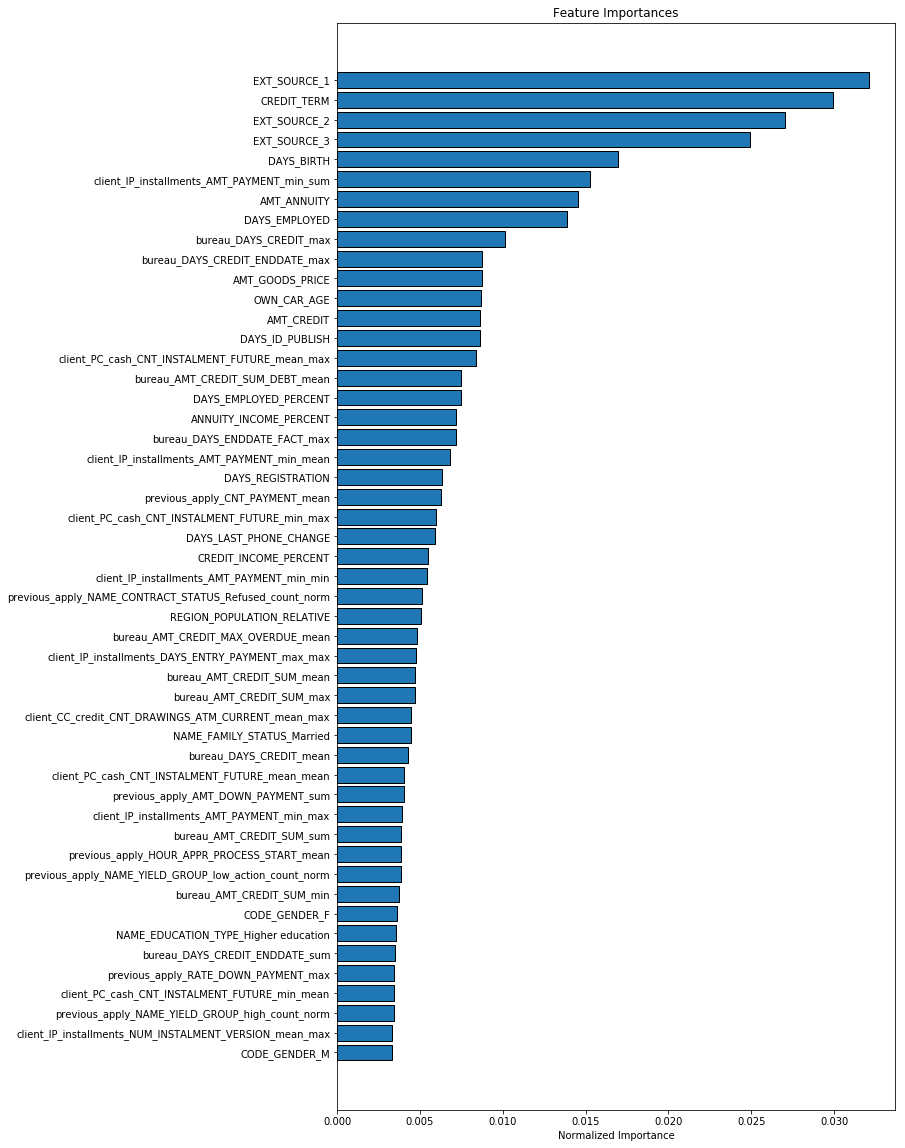

In [76]:
fi_sorted = plot_feature_importances(feat_import, 50)

In [73]:
feat_import.head()

,feature,importance
0,CNT_CHILDREN,1.775
1,AMT_INCOME_TOTAL,21.325
2,AMT_CREDIT,87.200
3,AMT_ANNUITY,146.700
4,AMT_GOODS_PRICE,87.900


In [75]:
feat_import.to_csv('feature_inportance_V16.csv', index = False)